In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading the data

usage = pd.read_csv("user_usage_daily.csv")
accounts = pd.read_csv("accounts.csv")

# Joining the data on portal_id
df = accounts.merge(usage)

In [3]:
# Looking at the data types

df.dtypes

name                 object
account_id           object
portal_id            object
type                 object
of_light_users      float64
of_regular_users    float64
of_admin_users      float64
company_size         object
churn_date           object
arr                 float64
user_id              object
queue_id             object
media_type           object
date                 object
dtype: object

### User engagement among ex-customers in the last 10 days before churning

In [4]:
# Changing the date columns to datetime format

df["churn_date"] = pd.to_datetime(df["churn_date"]).dt.normalize()
df["date"] = pd.to_datetime(df["date"]).dt.normalize()


# Creating a new column stating no. of days
# between these two dates

df["days_till_churn"] = df["churn_date"] - df["date"]


# Adding a new column that counts all the licenses

df["of_total_users"] = df["of_light_users"] + df["of_regular_users"] + df["of_admin_users"]

In [5]:
# Creating a df for ex-customers

ex_cust = df[(df["type"]=="Ex-customer") & 
             (df["churn_date"].isnull() == False) &                 # some churn dates are null, so we want to avoid these for the analysis
             (df["churn_date"] > df["date"])].reset_index()         # some churn dates are before the date of engagement, so we also want to avoid

ex_cust["use_before_churn"] = ex_cust["days_till_churn"].apply(lambda x: "Yes" if x.days < 11 else "No")

In [6]:
# Finding the number of users active in
# the last 10 days per expiring customer

ex_num_users = ex_cust[ex_cust["use_before_churn"]=="Yes"].groupby(["account_id","of_total_users","of_light_users","of_regular_users","of_admin_users","arr","company_size"])["user_id"].agg('nunique').reset_index()
ex_num_users.rename(columns={'user_id':'num_users_10days'}, inplace=True)

In [7]:
# Finding all the accounts where no users
# engaged in the last 10 days

ex_no_use_10days = pd.DataFrame(ex_cust[~ex_cust["account_id"].isin(ex_num_users["account_id"])]["account_id"].unique())
ex_no_use_10days.rename(columns={0:'account_id'}, inplace=True)
ex_no_use_10days = ex_no_use_10days.merge(accounts[["account_id","company_size"]])
ex_no_use_10days["num_users_10days"] = 0

In [8]:
# Making the final dataframe
ex_cust_engagement = pd.concat([ex_num_users,ex_no_use_10days],axis=0)

print("Out of all", len(ex_cust_engagement), "churned accounts", 
      len(ex_cust_engagement[ex_cust_engagement["company_size"]=="2.Mid-Market"]),
      "were mid-market sized, while",
      len(ex_cust_engagement[ex_cust_engagement["company_size"]=="3.Enterprise"]),
      "were enterprise sized \n")

print("In the", len(ex_cust_engagement[ex_cust_engagement["company_size"]=="2.Mid-Market"]),
      "mid-market churned accounts, the total number of users active were",
      round(ex_cust_engagement[ex_cust_engagement["company_size"]=="2.Mid-Market"]["num_users_10days"].sum()))
      
print("The avg. number of users per churning mid-market customer in their last 10 days is",
     round(ex_cust_engagement[ex_cust_engagement["company_size"]=="2.Mid-Market"]["num_users_10days"].sum()//len(ex_cust_engagement[ex_cust_engagement["company_size"]=="2.Mid-Market"])),'\n')

print("In the", len(ex_cust_engagement[ex_cust_engagement["company_size"]=="3.Enterprise"]),
      "enterprise churned accounts, the total number of users active were",
      round(ex_cust_engagement[ex_cust_engagement["company_size"]=="3.Enterprise"]["num_users_10days"].sum()))
      
print("The avg. number of users per churning enterprise customer in their last 10 days is",
     round(ex_cust_engagement[ex_cust_engagement["company_size"]=="3.Enterprise"]["num_users_10days"].sum()//len(ex_cust_engagement[ex_cust_engagement["company_size"]=="3.Enterprise"])),'\n')

Out of all 33 churned accounts 24 were mid-market sized, while 9 were enterprise sized 

In the 24 mid-market churned accounts, the total number of users active were 96
The avg. number of users per churning mid-market customer in their last 10 days is 4 

In the 9 enterprise churned accounts, the total number of users active were 36
The avg. number of users per churning enterprise customer in their last 10 days is 4 



### User engagement among current customers in the last 10 days of 2021

In [9]:
# Creating a new column with last day of the year

df["last_day_2021"] = "2021-12-31"
df["last_day_2021"] = pd.to_datetime(df["last_day_2021"]).dt.normalize()


# Creating a new column stating no. of days
# between this day and the day of engagement

df["days_till_last_day_2021"] = df["last_day_2021"] - df["date"]

In [10]:
# Removing the accounts that are actually ex-customers

non_customers = pd.concat(g for _, g in accounts.groupby("account_id") if len(g) > 1)["account_id"].unique()


# Creating a df for current customers engaging
# in last 10 days of 2021

curr_cust = df[(df["type"]=="Customer") &
               (~df["account_id"].isin(non_customers))].reset_index(drop=True)


# Clarifying if a user has used it in last 10 days

curr_cust["use_end_2021"] = curr_cust["days_till_last_day_2021"].apply(lambda x: "Yes" if x.days < 11 else "No")

In [11]:
# Finding the number of users active in
# the last 10 days of 2021 per customer

curr_num_users = curr_cust[curr_cust["use_end_2021"]=="Yes"].groupby(["account_id","of_total_users","of_light_users","of_regular_users","of_admin_users","arr","company_size"])["user_id"].agg('nunique').reset_index()
curr_num_users.rename(columns={'user_id':'num_users_10days'}, inplace=True)

In [12]:
# Finding all the accounts where no users
# engaged in the last 10 days

no_use_10days = pd.DataFrame(curr_cust[~curr_cust["account_id"].isin(curr_num_users["account_id"])]["account_id"].unique())
no_use_10days.rename(columns={0:'account_id'}, inplace=True)
no_use_10days = no_use_10days.merge(accounts[["account_id","company_size"]])
no_use_10days["num_users_10days"] = 0

In [13]:
# Making the final dataframe
curr_cust_engagement = pd.concat([curr_num_users,no_use_10days],axis=0)


print("Out of all", len(curr_cust_engagement), "current accounts", 
      len(curr_cust_engagement[curr_cust_engagement["company_size"]=="2.Mid-Market"]),
      "are mid-market sized, while",
      len(curr_cust_engagement[curr_cust_engagement["company_size"]=="3.Enterprise"]),
      "are enterprise sized \n")

print("In the", len(curr_cust_engagement[curr_cust_engagement["company_size"]=="2.Mid-Market"]),
      "mid-market accounts, the total number of users active were",
      round(curr_cust_engagement[curr_cust_engagement["company_size"]=="2.Mid-Market"]["num_users_10days"].sum()))
      
print("The avg. number of users per mid-market customer in their last 10 days of 2021 is",
     round(curr_cust_engagement[curr_cust_engagement["company_size"]=="2.Mid-Market"]["num_users_10days"].sum()//len(curr_cust_engagement[curr_cust_engagement["company_size"]=="2.Mid-Market"])),'\n')

print("In the", len(curr_cust_engagement[curr_cust_engagement["company_size"]=="3.Enterprise"]),
      "enterprise accounts, the total number of users active were",
      round(curr_cust_engagement[curr_cust_engagement["company_size"]=="3.Enterprise"]["num_users_10days"].sum()))
      
print("The avg. number of users per churning enterprise customer in their last 10 days is",
     round(curr_cust_engagement[curr_cust_engagement["company_size"]=="3.Enterprise"]["num_users_10days"].sum()//len(curr_cust_engagement[curr_cust_engagement["company_size"]=="3.Enterprise"])),'\n')

Out of all 687 current accounts 443 are mid-market sized, while 244 are enterprise sized 

In the 443 mid-market accounts, the total number of users active were 5282
The avg. number of users per mid-market customer in their last 10 days of 2021 is 11 

In the 244 enterprise accounts, the total number of users active were 4953
The avg. number of users per churning enterprise customer in their last 10 days is 20 



### Comparing user engagement types between churning users and users at the end of 2021

The analysis below shows us that users at the end of churning accounts have really similar activity to customers at the end of 2021.

In [14]:
# Finding how users from expiring accounts
# are interacting with the product

ex_cust_queues = pd.get_dummies(ex_cust[ex_cust["use_before_churn"]=="Yes"]["queue_id"])
ex_cust = pd.concat([ex_cust[ex_cust["use_before_churn"]=="Yes"],ex_cust_queues],axis=1)
ex_queues_users = ex_cust.groupby("account_id")[ex_cust_queues.columns].agg('sum').reset_index()

# Summing each type of user queue
ex_queues_users = ex_queues_users.iloc[:,1:].T
ex_queues_users["sum"] = ex_queues_users.sum(axis=1)
ex_queues_users = ex_queues_users.iloc[:,-1:]
ex_queues_users = ex_queues_users.sort_values("sum")

In [15]:
# Finding how users from the accounts are interacting 
# with the product in last 10 days of 2021

curr_cust_queues = pd.get_dummies(curr_cust[curr_cust["use_end_2021"]=="Yes"]["queue_id"])
curr_cust_1 = pd.concat([curr_cust[curr_cust["use_end_2021"]=="Yes"],curr_cust_queues],axis=1)
curr_queues_users = curr_cust_1.groupby("account_id")[curr_cust_queues.columns].agg('sum').reset_index()

# Summing each type of user queue
curr_queues_users = curr_queues_users.iloc[:,1:].T
curr_queues_users["sum"] = curr_queues_users.sum(axis=1)
curr_queues_users = curr_queues_users.iloc[:,-1:]
curr_queues_users = curr_queues_users.sort_values("sum")

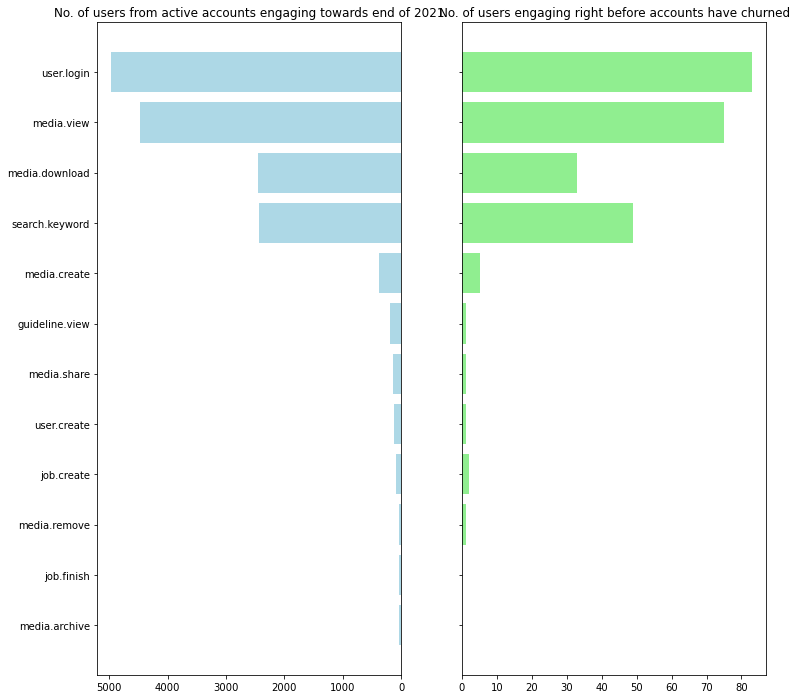

In [16]:
fig, axes = plt.subplots(ncols=2, sharey=True,figsize=(12,12))
axes[0].barh(curr_queues_users.index, curr_queues_users["sum"], align='center', color='lightblue')
axes[1].barh(ex_queues_users.index, ex_queues_users["sum"], align='center', color='lightgreen')
axes[0].invert_xaxis()
axes[0].set(title='No. of users from active accounts engaging towards end of 2021')
axes[1].set(title='No. of users engaging right before accounts have churned')
plt.show()

We can also see that users from active accounts interact the same year-round, from the analysis below.

In [17]:
# Finding how users from the accounts are interacting 
# with the product outside of last 10 days of 2021

curr_cust_queues_2 = pd.get_dummies(curr_cust[curr_cust["use_end_2021"]=="No"]["queue_id"])
curr_cust_2 = pd.concat([curr_cust[curr_cust["use_end_2021"]=="No"],curr_cust_queues_2],axis=1)
curr_queues_users_2 = curr_cust_2.groupby("account_id")[curr_cust_queues_2.columns].agg('sum').reset_index()

# Summing each type of user queue
curr_queues_users_2 = curr_queues_users_2.iloc[:,1:].T
curr_queues_users_2["sum"] = curr_queues_users_2.sum(axis=1)
curr_queues_users_2 = curr_queues_users_2.iloc[:,-1:]
curr_queues_users_2 = curr_queues_users_2.sort_values("sum")

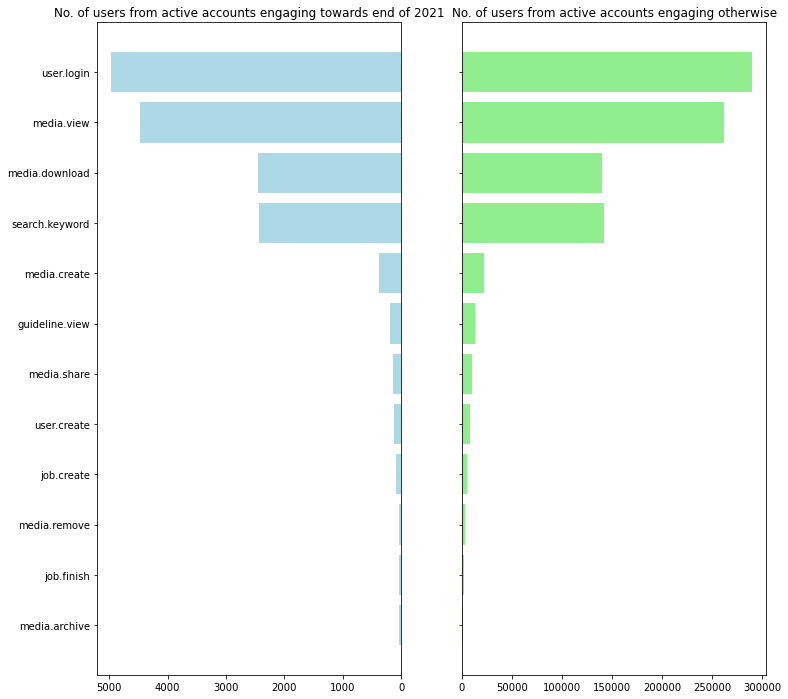

In [18]:
fig, axes = plt.subplots(ncols=2, sharey=True,figsize=(12,12))
axes[0].barh(curr_queues_users.index, curr_queues_users["sum"], align='center', color='lightblue')
axes[1].barh(curr_queues_users_2.index, curr_queues_users_2["sum"], align='center', color='lightgreen')
axes[0].invert_xaxis()
axes[0].set(title='No. of users from active accounts engaging towards end of 2021')
axes[1].set(title='No. of users from active accounts engaging otherwise')
plt.show()

### Engagement ratio vs. Revenue of current customers

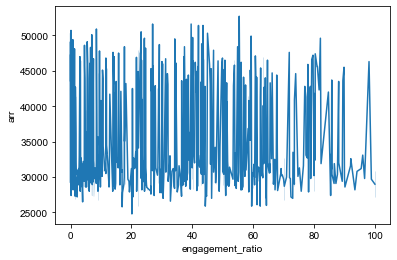

In [19]:
# Finding the number of users active

curr_cust_engrate = curr_cust.groupby(["account_id","of_total_users","of_light_users","of_regular_users","of_admin_users","arr","company_size"])["user_id"].agg('nunique').reset_index()
curr_cust_engrate.rename(columns={'user_id':'num_users'}, inplace=True)


# Calculating the engagement ratio of users

curr_cust_engrate["engagement_ratio"] = (curr_cust_engrate["num_users"] / curr_cust_engrate["of_total_users"]) * 100


# Plotting only those that have lower than 100%
# engagement ratio, as otherwise is inaccurate
sns.lineplot(data=curr_cust_engrate[curr_cust_engrate["engagement_ratio"] <= 100], 
             x="engagement_ratio", 
             y="arr");
sns.set(rc={'figure.figsize':(11.7,8.27)})


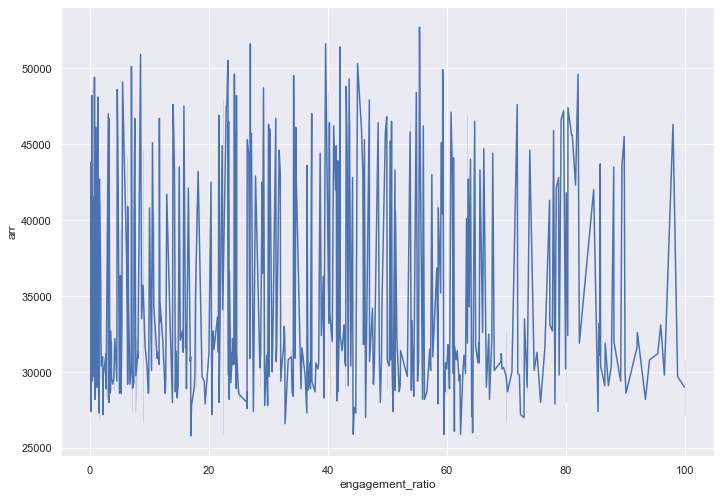

In [20]:
# Evaluating if there is a relationship if looking
# at those with less than 1000 light users

sns.lineplot(data=curr_cust_engrate[(curr_cust_engrate["engagement_ratio"] <= 100) & 
                                (curr_cust_engrate["of_light_users"]<1000)], 
             x="engagement_ratio", 
             y="arr");

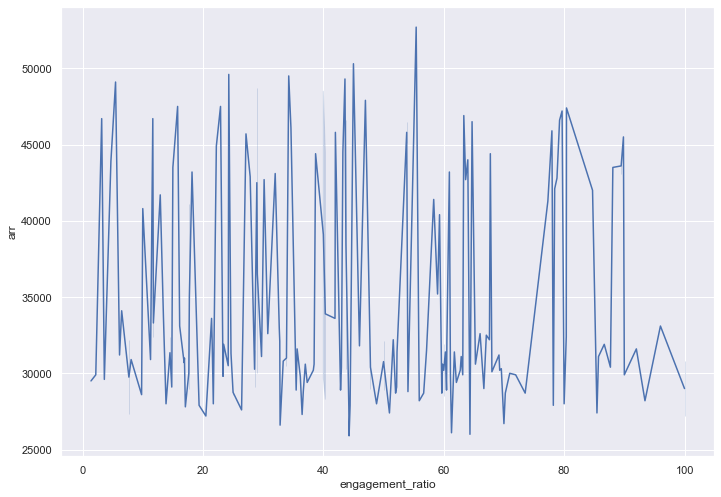

In [21]:
# Evaluating if there is a relationship if looking
# at those with less than 100 light users

sns.lineplot(data=curr_cust_engrate[(curr_cust_engrate["engagement_ratio"] <= 100) & 
                                (curr_cust_engrate["of_light_users"]<100)], 
             x="engagement_ratio", 
             y="arr");

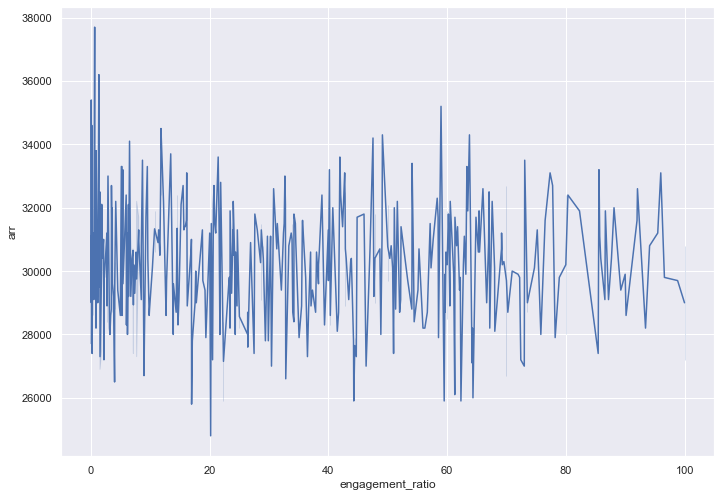

In [22]:
# Evaluating if there is a relationship if
# looking at solely mid-sized companies

sns.lineplot(data=curr_cust_engrate[(curr_cust_engrate["engagement_ratio"] <= 100) & 
                                (curr_cust_engrate["company_size"]=="2.Mid-Market")], 
             x="engagement_ratio", 
             y="arr");

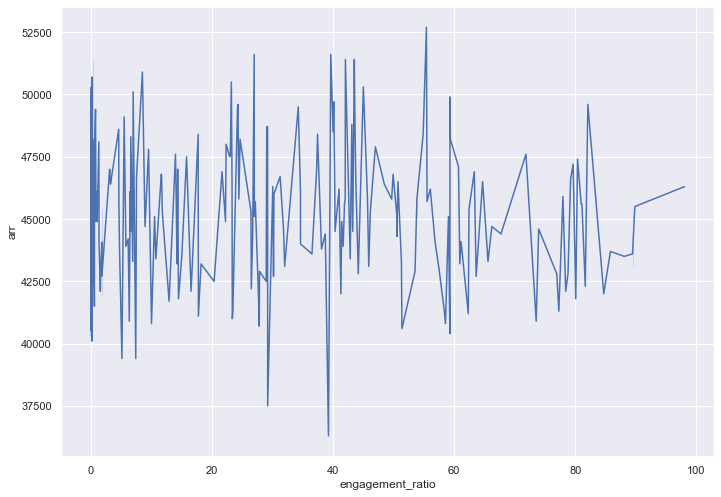

In [23]:
# Evaluating if there is a relationship if
# looking at solely enterprise companies

sns.lineplot(data=curr_cust_engrate[(curr_cust_engrate["engagement_ratio"] <= 100) & 
                                (curr_cust_engrate["company_size"]=="3.Enterprise")], 
             x="engagement_ratio", 
             y="arr");

There seems to be no relationship whatsoever between engagement ratio and annual revenue from customers, from the above analyses

In [24]:
# Exporting to csv

ex_cust_engagement = ex_cust_engagement[["account_id","company_size","num_users_10days"]]
ex_cust_engagement["engagement_ratio"] = np.nan
ex_cust_engagement["type"] = "Ex-customer"

curr_cust_engagement = curr_cust_engrate[["account_id","company_size","engagement_ratio"]].merge(curr_cust_engagement[["account_id","company_size","num_users_10days"]])
curr_cust_engagement["type"] = "Customer"

customer_engagement = pd.concat([ex_cust_engagement,curr_cust_engagement]).reset_index(drop=True)
customer_engagement = customer_engagement.replace(np.inf, np.nan)

customer_engagement.to_csv("customer_engagement.csv")

### Insights:

- Insight 1: it is clear from this descriptive analysis that churning customers have an extremely low engagement rate, with 4 on average. This is interesting however because churn may be able to be detected correctly with engagement frequency.


- Insight 2: it is unclear to detect churn simply from the types of engagement. For example, customers at the end of the year who remained a customer acted very similar with the product to both churned customers and customers all year round.


- Insight 3: there is no relationship between engagement ratio and revenue from the customers. 

### Actionables

- Suggestion 1: We can set up live dashboards specialised for each account manager to monitor and signal license consumption. They can further diagnose the issue by reaching out to the customer, e.g. the company originally bought 150 licenses but only a core team of 15 rely on the product and that's why their engagement levels are extremely low.


- Suggestion 2: We can also see if the trends repeat in the previous few years, assuming the data exists. We can then use these insights in the existing churn prediction model and test for possible improvements. 


- Suggestion 3: We can strategically engage with continuously low-engagement customers, from both mid-market and enterprise sized companies, and attempt to understand what are the factors that are retaining them.

## Setting Engagement ratio as a key KPI for 2022

In [25]:
print("The average engagement rate for mid-market accounts is",
      customer_engagement[(customer_engagement["company_size"]=="2.Mid-Market") & 
                          (customer_engagement["engagement_ratio"] <= 100)]["engagement_ratio"].mean(),'\n',
      "while the average engagement rate for enterprise accounts is",
      customer_engagement[(customer_engagement["company_size"]=="3.Enterprise") & 
                          (customer_engagement["engagement_ratio"] <= 100)]["engagement_ratio"].mean())      

The average engagement rate for mid-market accounts is 33.0102506800774 
 while the average engagement rate for enterprise accounts is 29.04678224208093


In [26]:
print("The customer churn rate in 2021 was", 
      len(customer_engagement[customer_engagement["type"] == "Ex-customer"])/len(customer_engagement[customer_engagement["type"] == "Customer"]))

The customer churn rate in 2021 was 0.048672566371681415


The target engagement ratio to achieve for 2022 I would suggest to establish would be 40% for mid-market accounts and 33% for enterprise accounts, because:

- from my experience in product, this growth seem achievable especially with methods implemented to mitigate churning customers;


- we can see that there is no relationship between high engaging customers and the revenue that they bring in, hence setting higher-than-average standards for engagement ratio at this stage of the product may not be necessary at this point in time.

I would set an additional target, which would be to have less than 3% of customers fall under 10% engagement ratio, because:

- we know since decreasing engagement ratios lead to churning customers, we can improve the performance of 4.8% churn rate in 2021.